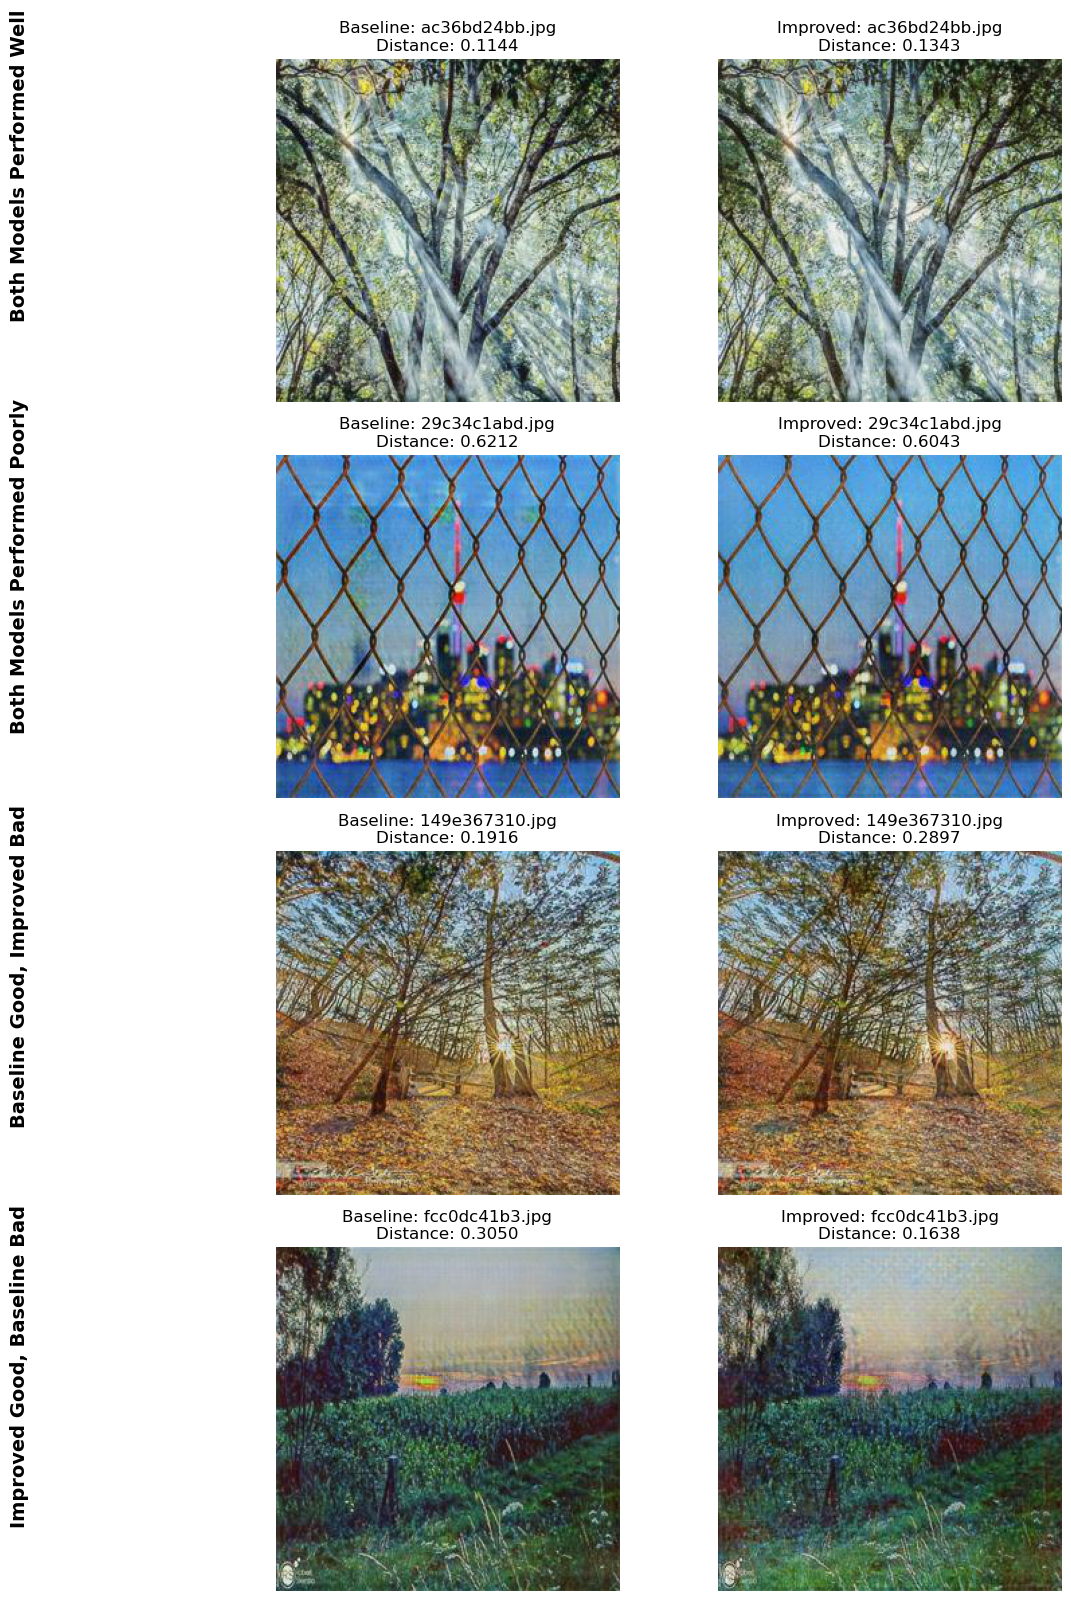

In [ ]:
import os
import csv
from pathlib import Path
from typing import Dict, List, Tuple, Union

import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

def _list_images(folder: Union[str, Path]) -> List[str]:
    folder = Path(folder)
    exts = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG")
    files: List[str] = []
    for e in exts:
        files += [str(p) for p in folder.glob(e)]
    return sorted(files)

def _load_and_preprocess(paths: List[str], target_size=(299, 299), batch: int = 32):
    for i in range(0, len(paths), batch):
        batch_paths = paths[i : i + batch]
        imgs = []
        for p in batch_paths:
            raw = tf.io.read_file(p)
            img = tf.image.decode_image(raw, channels=3, expand_animations=False)
            img = tf.image.resize(img, target_size)
            img = tf.cast(img, tf.float32)  # 0..255
            imgs.append(img)
        x = tf.stack(imgs, axis=0)
        yield preprocess_input(x.numpy())  # -> [-1, 1]

def _get_inception_features(paths: List[str], model: tf.keras.Model, batch: int = 32) -> np.ndarray:
    feats = []
    for x in _load_and_preprocess(paths, batch=batch):
        f = model.predict(x, verbose=0)  # [B, 2048]
        feats.append(f)
    return np.concatenate(feats, axis=0)

def _cosine_distance_matrix(A: np.ndarray, B: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    A_n = A / (np.linalg.norm(A, axis=1, keepdims=True) + eps)
    B_n = B / (np.linalg.norm(B, axis=1, keepdims=True) + eps)
    sim = A_n @ B_n.T
    return 1.0 - sim  

def compute_per_image_distances(gen_dir: Union[str, Path], real_dir: Union[str, Path], batch: int = 64) -> Dict:

    gen_paths = _list_images(gen_dir)
    real_paths = _list_images(real_dir)
    
    if not gen_paths:
        raise FileNotFoundError(f"No images in generated dir: {gen_dir}")
    if not real_paths:
        raise FileNotFoundError(f"No images in real dir: {real_dir}")
    
    inc = InceptionV3(include_top=False, pooling="avg", input_shape=(299, 299, 3))
    
    f_gen = _get_inception_features(gen_paths, inc, batch=batch)
    f_real = _get_inception_features(real_paths, inc, batch=batch)
    
    D = _cosine_distance_matrix(f_gen, f_real) 
    d_per_gen = D.min(axis=1)  
    
    results = {
        'image_names': [Path(p).name for p in gen_paths],
        'image_paths': gen_paths,
        'distances': d_per_gen.tolist(),
        'gen_features': f_gen,
        'real_features': f_real
    }
    
    return results

def find_comparison_examples(model1_results: Dict, model2_results: Dict, percentile: float = 20.0) -> Dict:

    names1 = set(model1_results['image_names'])
    names2 = set(model2_results['image_names'])
    common_names = names1.intersection(names2)
    
    if not common_names:
        return {}
    
    name_to_dist1 = dict(zip(model1_results['image_names'], model1_results['distances']))
    name_to_dist2 = dict(zip(model2_results['image_names'], model2_results['distances']))
    
    common_distances1 = [name_to_dist1[name] for name in common_names]
    common_distances2 = [name_to_dist2[name] for name in common_names]
    common_names_list = list(common_names)
    
    thresh1_good = np.percentile(common_distances1, percentile)
    thresh1_bad = np.percentile(common_distances1, 100 - percentile)
    thresh2_good = np.percentile(common_distances2, percentile)
    thresh2_bad = np.percentile(common_distances2, 100 - percentile)
    
    examples = {
        'both_good': [],
        'both_bad': [],
        'model1_good_model2_bad': [],
        'model2_good_model1_bad': []
    }
    
    for name, dist1, dist2 in zip(common_names_list, common_distances1, common_distances2):
        if dist1 <= thresh1_good and dist2 <= thresh2_good:
            examples['both_good'].append((name, dist1, dist2))
        
        elif dist1 >= thresh1_bad and dist2 >= thresh2_bad:
            examples['both_bad'].append((name, dist1, dist2))
        
        elif dist1 <= thresh1_good and dist2 >= thresh2_bad:
            examples['model1_good_model2_bad'].append((name, dist1, dist2))
        
        elif dist2 <= thresh2_good and dist1 >= thresh1_bad:
            examples['model2_good_model1_bad'].append((name, dist1, dist2))
    
    for category in examples:
        if category in ['both_good', 'model1_good_model2_bad']:
            examples[category].sort(key=lambda x: x[1])
        elif category == 'both_bad':
            examples[category].sort(key=lambda x: x[1] + x[2], reverse=True)
        else:  
            examples[category].sort(key=lambda x: x[2])
    
    return examples

def display_comparison_results(examples: Dict, model1_gen_dir: str, model2_gen_dir: str, 
                             model1_name: str = "Baseline", model2_name: str = "Improved"):
    
    categories = [
        ('both_good', 'Both Models Performed Well'),
        ('both_bad', 'Both Models Performed Poorly'),
        ('model1_good_model2_bad', f'{model1_name} Good, {model2_name} Bad'),
        ('model2_good_model1_bad', f'{model2_name} Good, {model1_name} Bad')
    ]
    
    fig, axes = plt.subplots(len(categories), 2, figsize=(12, 4 * len(categories)))
    if len(categories) == 1:
        axes = np.array([axes])
    
    for row, (category, title) in enumerate(categories):
        if category in examples and examples[category]:
            name, dist1, dist2 = examples[category][0]
            
            img1_path = Path(model1_gen_dir) / name
            img2_path = Path(model2_gen_dir) / name
            
            if img1_path.exists() and img2_path.exists():
                img1 = Image.open(img1_path)
                img2 = Image.open(img2_path)
                
                axes[row, 0].imshow(img1)
                axes[row, 0].set_title(f'{model1_name}: {name}\nDistance: {dist1:.4f}')
                axes[row, 0].axis('off')
                
                axes[row, 1].imshow(img2)
                axes[row, 1].set_title(f'{model2_name}: {name}\nDistance: {dist2:.4f}')
                axes[row, 1].axis('off')
            else:
                axes[row, 0].text(0.5, 0.5, 'Image not found', ha='center', va='center')
                axes[row, 1].text(0.5, 0.5, 'Image not found', ha='center', va='center')
                axes[row, 0].axis('off')
                axes[row, 1].axis('off')
        else:
            axes[row, 0].text(0.5, 0.5, f'No examples\nfor {title}', ha='center', va='center')
            axes[row, 1].text(0.5, 0.5, f'No examples\nfor {title}', ha='center', va='center')
            axes[row, 0].axis('off')
            axes[row, 1].axis('off')
        
        fig.text(0.02, 0.9 - (row * 0.25), title, fontsize=14, fontweight='bold', rotation=90, va='center')
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.15)
    plt.show()


BASELINE_GEN_DIR = "./cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/experiments/seed_0029/generated_full/"
BASELINE_REAL_DIR = "./cygan_preproc_REAL_data_50epochs/cygan_preproc_REAL_data_30epochs/monet_jpgs_for_eval/"

IMPROVED_GEN_DIR = "./ours_preproccess_data_50epochs/experiments/seed_0029/generated_full/"
IMPROVED_REAL_DIR = "./ours_preproccess_data_50epochs/monet_jpgs_for_eval/"

baseline_results = compute_per_image_distances(BASELINE_GEN_DIR, BASELINE_REAL_DIR)
improved_results = compute_per_image_distances(IMPROVED_GEN_DIR, IMPROVED_REAL_DIR)

examples = find_comparison_examples(baseline_results, improved_results, percentile=20.0)

display_comparison_results(examples, BASELINE_GEN_DIR, IMPROVED_GEN_DIR, 
                         model1_name="Baseline", model2_name="Improved")

Found 7038 common images between models
Found 7 examples where ablated is bad and improved is good


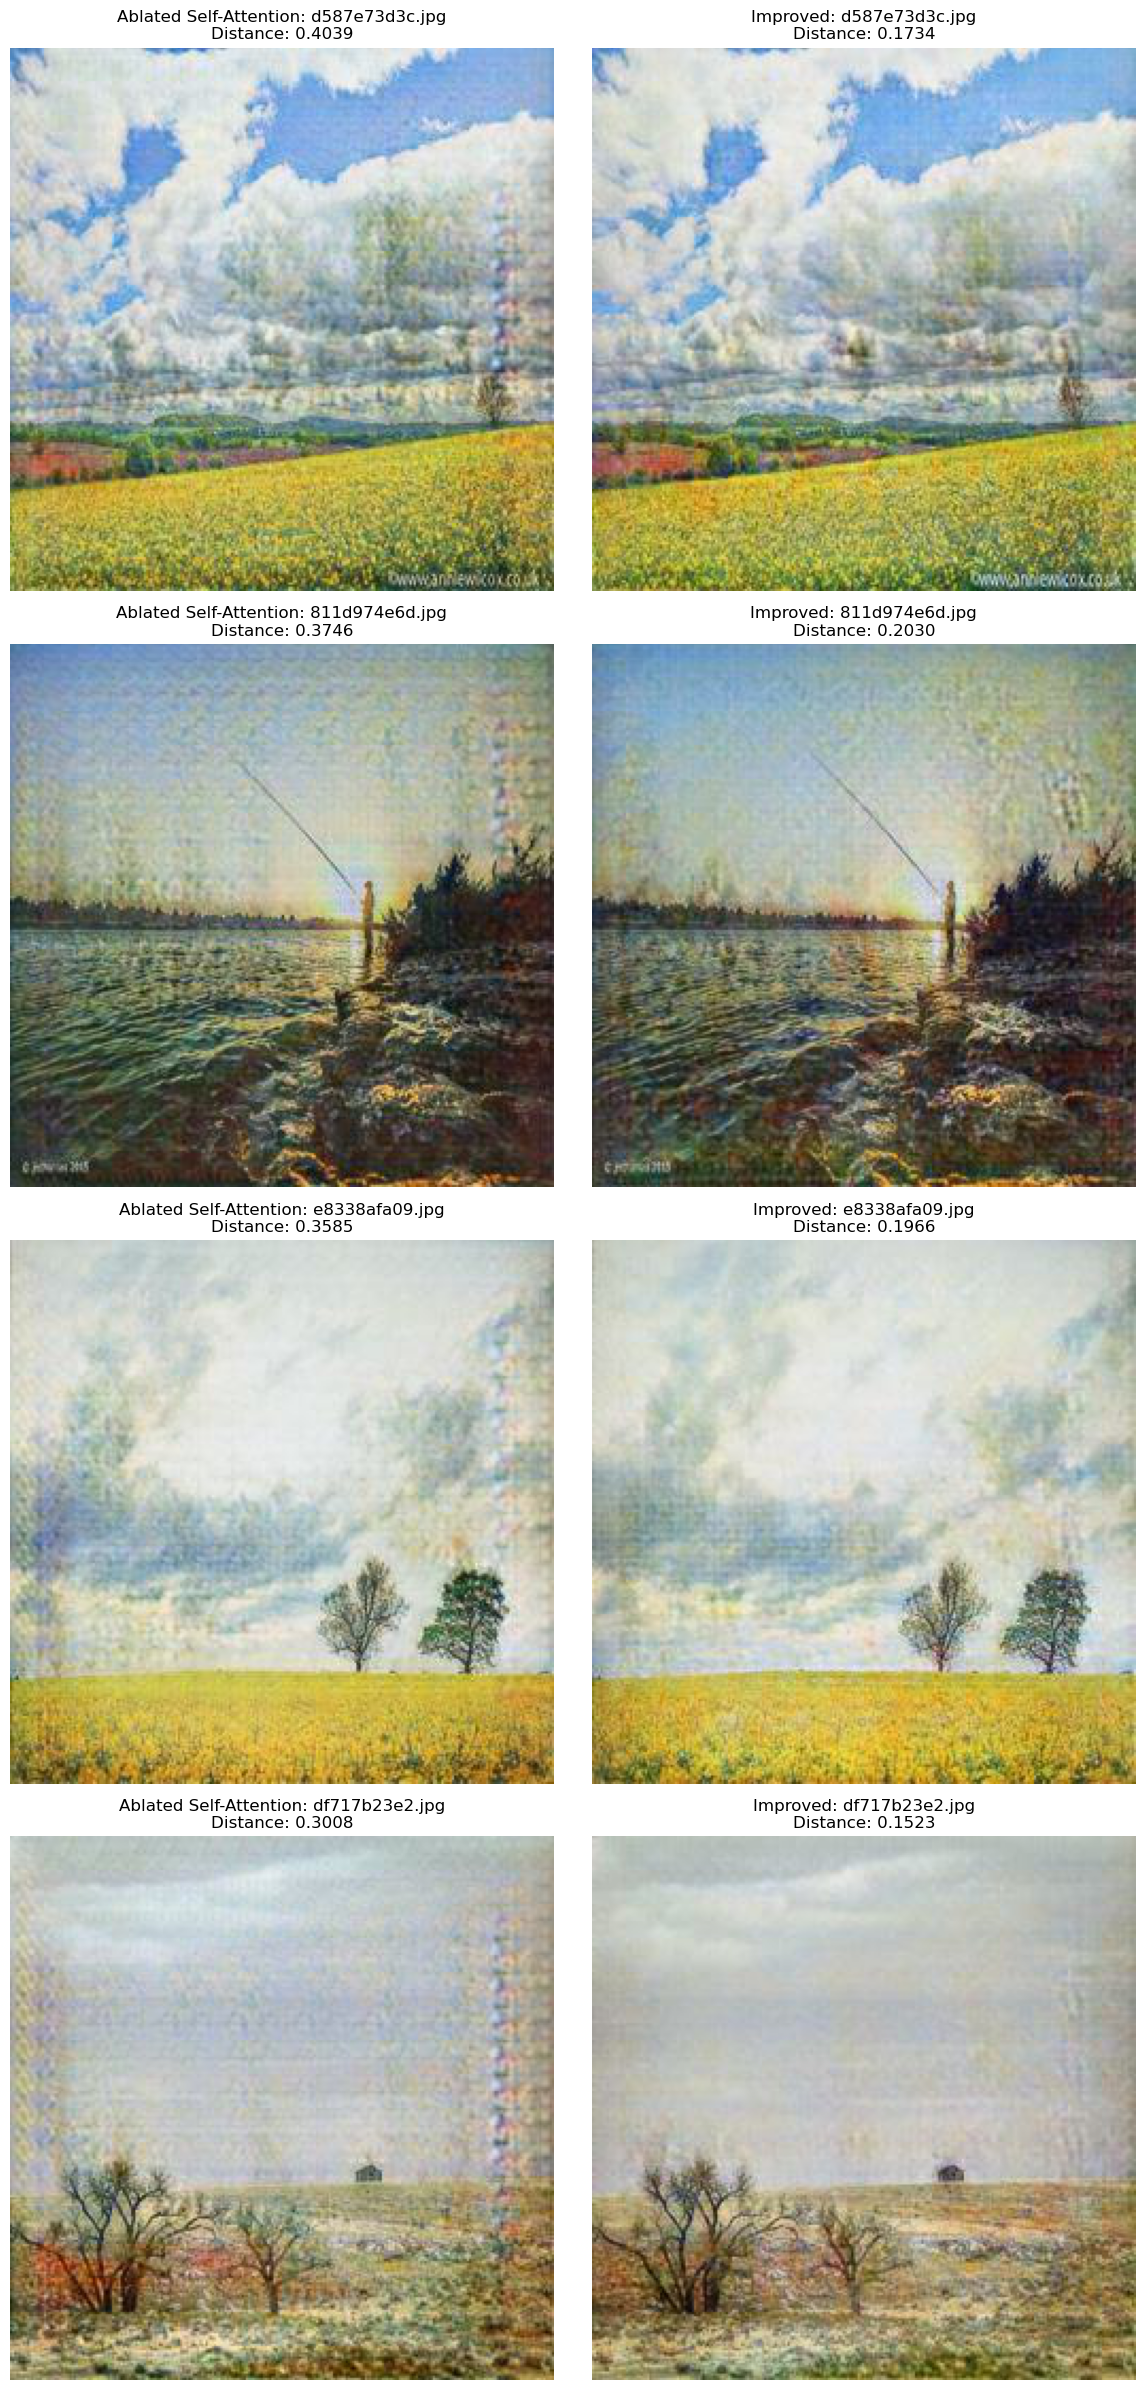

In [15]:
def show_multiple_ablated_bad_improved_good(ablated_results: Dict, improved_results: Dict, 
                                           ablated_gen_dir: str, improved_gen_dir: str, 
                                           percentile: float = 20.0, num_examples: int = 6):

    
    names_ablated = set(ablated_results['image_names'])
    names_improved = set(improved_results['image_names'])
    common_names = names_ablated.intersection(names_improved)
    
    print(f"Found {len(common_names)} common images between models")
    
    name_to_dist_ablated = dict(zip(ablated_results['image_names'], ablated_results['distances']))
    name_to_dist_improved = dict(zip(improved_results['image_names'], improved_results['distances']))
    
    common_distances_ablated = [name_to_dist_ablated[name] for name in common_names]
    common_distances_improved = [name_to_dist_improved[name] for name in common_names]
    common_names_list = list(common_names)
    
    thresh_ablated_bad = np.percentile(common_distances_ablated, 100 - percentile)  # Top 20% = bad
    thresh_improved_good = np.percentile(common_distances_improved, percentile)  # Bottom 20% = good
    

    
    examples = []
    for name, dist_ablated, dist_improved in zip(common_names_list, common_distances_ablated, common_distances_improved):
        if dist_ablated >= thresh_ablated_bad and dist_improved <= thresh_improved_good:
            examples.append((name, dist_ablated, dist_improved))
    
    examples.sort(key=lambda x: x[1] - x[2], reverse=True)
    
    if not examples:
        print("No examples found where ablated model is bad and improved model is good!")
        return
    
    print(f"Found {len(examples)} examples where ablated is bad and improved is good")
    
    num_to_show = min(num_examples, len(examples))
    

    cols = 2  
    rows = num_to_show
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_to_show):
        name, dist_ablated, dist_improved = examples[i]
        
        # Load and display images
        img_ablated_path = Path(ablated_gen_dir) / name
        img_improved_path = Path(improved_gen_dir) / name
        
        if img_ablated_path.exists() and img_improved_path.exists():
            img_ablated = Image.open(img_ablated_path)
            img_improved = Image.open(img_improved_path)
            
            axes[i, 0].imshow(img_ablated)
            axes[i, 0].set_title(f'Ablated Self-Attention: {name}\nDistance: {dist_ablated:.4f}')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(img_improved)
            axes[i, 1].set_title(f'Improved: {name}\nDistance: {dist_improved:.4f}')
            axes[i, 1].axis('off')
            

        else:
            axes[i, 0].text(0.5, 0.5, f'Image not found\n{name}', ha='center', va='center')
            axes[i, 1].text(0.5, 0.5, f'Image not found\n{name}', ha='center', va='center')
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Define paths
    ablated_GEN_DIR = "./ablation-attention/experiments/seed_0029/generated_full/"
    ablated_REAL_DIR = "./ablation-attention/monet_jpgs_for_eval/"

    IMPROVED_GEN_DIR = "./ours_preproccess_data_50epochs/experiments/seed_0029/generated_full/"
    IMPROVED_REAL_DIR = "./ours_preproccess_data_50epochs/monet_jpgs_for_eval/"


    ablated_results = compute_per_image_distances(ablated_GEN_DIR, ablated_REAL_DIR)

    improved_results = compute_per_image_distances(IMPROVED_GEN_DIR, IMPROVED_REAL_DIR)

    show_multiple_ablated_bad_improved_good(ablated_results, improved_results, 
                                           ablated_GEN_DIR, IMPROVED_GEN_DIR, 
                                           num_examples=4)

